In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [341]:
# Setup folder for data

# Get current working directory
cwd = os.getcwd()

# Set data folder location
data_loc = os.path.join(cwd, "Data")

# Search for data folder
if "Data" not in os.listdir(cwd):

    # Create data folder if not found
    os.makedirs(data_loc)

In [366]:
#Create a clean data set of a specified size
def create_data(size):

    x_vals = [np.linspace(0, np.random.randint(1,20)*np.pi, 1000) for i in range(size)]
    y_vals = [np.sin(x) for x in x_vals]
    classification = ["Clean" for x in x_vals]
            
    entry = {
        "X": x_vals,
        "Y": y_vals,
        "Classification": classification
    }

    return entry

#Create a noisy array from an array of input x-values
def apply_noise(xarr):
    return [np.sin(x) + np.random.normal(0, 1, 1000) for x in xarr]

In [367]:
#Create 50 clean data sets with random periods
data_set = create_data(100)

x_vals = data_set["X"]
y_vals = data_set["Y"]
classification = data_set["Classification"]

#Create a noisy data set and classifier list 
y_vals_noise = apply_noise(x_vals)
classification_noise = ["Noisy" for i in range(len(x_vals))]

data_set["X"] = x_vals + x_vals
data_set["Y"] = y_vals + y_vals_noise
data_set["Classification"] = classification + classification_noise

In [368]:
#Create a pandas dataframe and export to the data location provided above
data = pd.DataFrame(data_set)
data.to_csv(f"{data_loc}/data.csv")

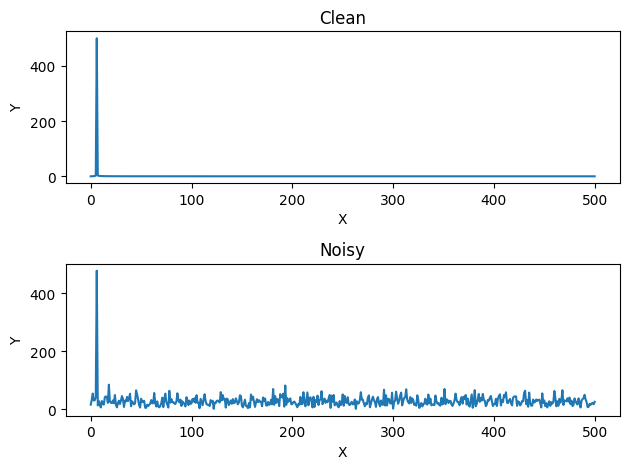

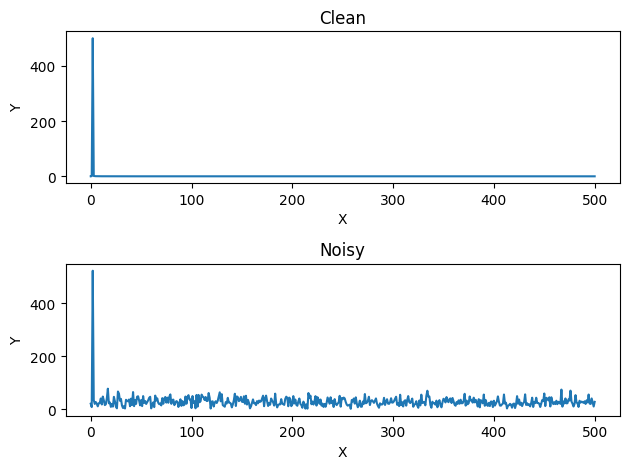

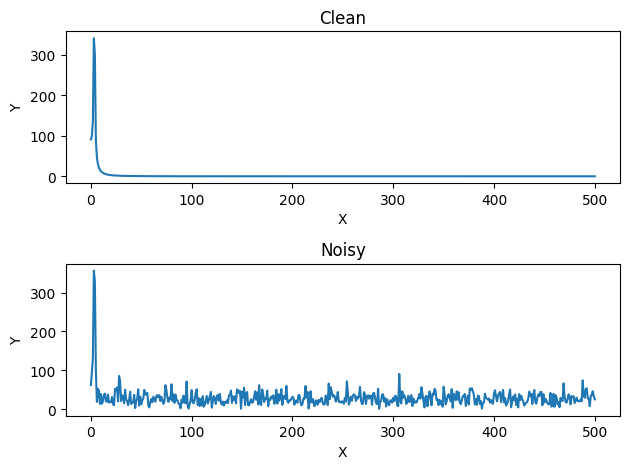

In [369]:
#Load each each column respectively
y_data = np.asarray(data["Y"])
x_data = np.asarray(data["X"])

#Create a random test index list
index = [np.random.randint(1,50) for x in range(3)]

#Loop over the index list and plot the respective noisy and clean functions
for i in index:
    plt.figure()
    plt.subplot(211)
    plt.title("Clean")
    plt.plot(np.abs(np.fft.rfft(y_data[i])))
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.subplot(212)
    plt.title("Noisy")
    plt.plot(np.abs(np.fft.rfft(y_data[i+100])))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()

In [370]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

(501,)
(501,)


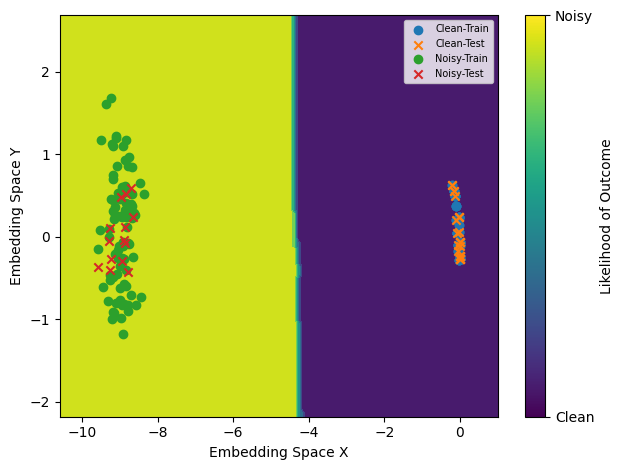

In [373]:
features = np.asarray([np.abs(np.fft.rfft(y_data[i])) for i in range(len(x_data))])

labels = data["Classification"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

print(X_train[0].shape)

emb = make_pipeline(MinMaxScaler(),  NeighborhoodComponentsAnalysis(n_components=2))

emb.fit(X_train, y_train)

x_train_transform = emb.transform(X_train)
x_test_transform = emb.transform(X_test)

clf = KNeighborsClassifier(n_neighbors=4)

clf.fit(x_train_transform, y_train)

embedded_features = np.append(x_train_transform, x_test_transform, axis=0)

disp = DecisionBoundaryDisplay.from_estimator(clf, embedded_features, response_method="predict_proba")

outcomes = ["Clean", "Noisy"]
for outcome in outcomes:
    x_train_outcome = x_train_transform[[y == outcome for y in y_train]]
    ax1 = disp.ax_.scatter(*x_train_outcome.T, label=f"{outcome}-Train")   
    x_test_outcome = x_test_transform[[y == outcome for y in y_test]]
    ax2 = disp.ax_.scatter(*x_test_outcome.T, label=f"{outcome}-Test", marker="x") 
    disp.ax_.legend(fontsize="7")
    disp.ax_.set_xlabel("Embedding Space X")
    disp.ax_.set_ylabel("Embedding Space Y")
cbar = disp.figure_.colorbar(ax1, label="Likelihood of Outcome", ticks=[0,1])
cbar.set_ticklabels(outcomes)
plt.tight_layout()
plt.show()



In [397]:
#Create new unseen dataset

x_new = np.linspace(0, 2*np.pi, 1000)
y_new_noisy = np.abs(np.fft.rfft(np.sin(x_new) + np.random.normal(0, 1, 1000)))
y_new_clean = np.abs(np.fft.rfft(2*np.sin(x_new) + 8*np.cos(x_new)))

noisy_result = clf.predict(emb.transform(y_new_noisy.reshape(1, -1)))
clean_result = clf.predict(emb.transform(y_new_clean.reshape(1, -1)))

print(f"Clean: {clean_result}")
print(f"Noisy: {noisy_result}")


Clean: ['Clean']
Noisy: ['Noisy']
